<a href="https://colab.research.google.com/github/May-Moon-Colab/Machine-Learning/blob/main/Project3_(NLP)_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project: SkimLit 📔🔥

In this notebook we'll build a NLP model to make reading medical abstracts easier. 

We're replicating the [PubMed 200K RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071), who contains 200k labelled Randomized Controlled Trial (RCT) abstracts using one of the following classes:

  * Background, Objetives, Method, Result or Conclusion

In that way, given the abstract of a RCT, we want to know what role does each sentece, for example:


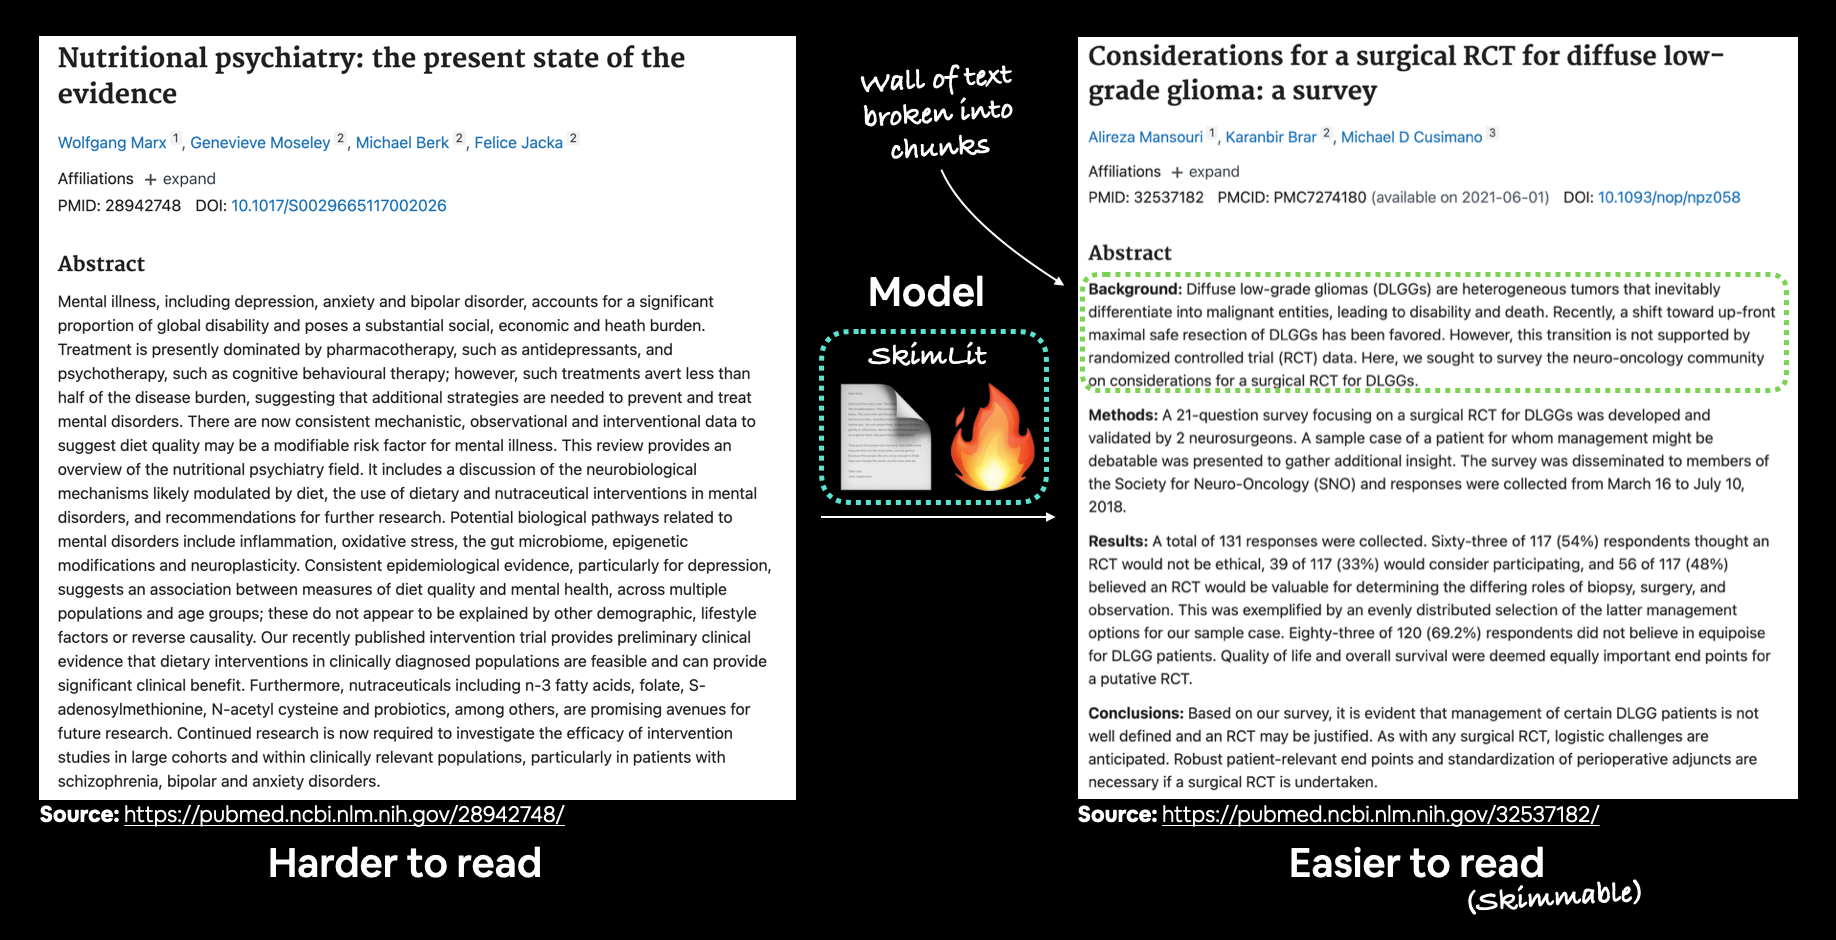

**Model input**

For example, can we train an NLP model which takes the following input (note: the following sample has had all numerical symbols replaced with "@"):



> To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ). A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks. Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers. Pain was assessed using the visual analog pain scale ( @-@ mm ).

**Model output**

And it returns the flowwing output:



> ['###24293578\n',

 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',

 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',

 'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n',
 'RESULTS\tThe mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively .\n',
 'RESULTS\tFurther , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group .\n',
 'RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']





## Imports for the project

In [ ]:
# Data Treatment
import os
import pandas as pd
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model



# Evaluating the models
!wget https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py
from helper_functions import calculate_results


--2023-03-15 23:13:34--  https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2023-03-15 23:13:34 (64.9 MB/s) - ‘helper_functions.py’ saved [10234/10234]



# Get the Data Ready

Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

This data are publically avalilable in the form of .txt files [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct)

Let's copy them to our local directory using `git clone` 

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.17 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


This repository had some different versions about the data, firts we're focus on his `PubMed_20k_RCT_numbers_replaced_with_at_sign`, because for begin this project we had to keep our experiments quick by starting with a smaller subset.

Let's check the file contents.

In [ ]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Looks like we've got three separate text files:
  * `train.txt` - training samples.
  * `dev.txt` - validation set.
  *  `test.txt` - test samples

In [ ]:
# Check all of the filenames in the target directory
data_dir = "/content/pubmed-rct/PubMed_20k_RCT/"

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT/test.txt']

## Preprocess the data

Now we've got some text data, it's time to become one with it,
And one of the best ways data is to...

> Visualize, visualize, visualize

So let's write a function to read in all of the lines of a target text file.


In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Read each line of our training data and convert it to a dictionary.
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

Reading this lines we need to write a function to made the `training_data` into something our model can read, for reaching that, the firts step is to make the data into a list of dictionarys with the following format:

    [{'line_number': 0,
    'target':[label],
    'text': [text_sample],
    total_lines: '#n_of_lines'}
    ...]

So, let's make a function to perform the following steps:
  1. Take a taget file.
  2. Read the lines in the target file.
  3. For each line in the target file
    * If the line begins with `###` mark it as an abstract ID and the beginning of a new abstract.
    * If the line begins with `\n` mark it as the end of an abstract sample.
    * Record the text before the \t as the label of the line.
    * Record the text after the \t as the label of the line.
  4. Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs.


In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Take a filename, opens it and return a list of dictionarys extratict things like the target label,
  text of the sentence, how many senteces are in the current abstract and what sentences nuumber the target line is.
  
  Args:
    filename

  Returns:
    A list of dictionaries. E.g:
       [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines= ""
  abstract_samples= []
  
  # Loop throught each line in target file
  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = "" # reset abstract string
      
    elif line.isspace(): # Check to see if line is a new Line.
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines.
      
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
       line_data = {} # Emply dict to store data from line
       target_text_split = abstract_line.split("\t") # split target label from text.
       line_data["target"] = target_text_split[0] # get target label.
       line_data["text"] = target_text_split[1].lower() # get target text.
       line_data["line_number"] = abstract_line_number # number of line which the line appear in the abstract.
       line_data["total_lines"] = len(abstract_line_split) -1 # total numbers of lines in the abstract.
       abstract_samples.append(line_data) # add line data to abstract samples list
  
    else: # if the above condictions aren't fulfilled, the line contains a labelled sentence.
     abstract_lines += line

  return abstract_samples 
    

Let's use it to preprocess each of our RCT 20k datasets

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+ "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples)

CPU times: user 363 ms, sys: 80.6 ms, total: 443 ms
Wall time: 446 ms


180040

In [ ]:
# Check the abstract of our training data
train_samples[:5]


[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the weste

Beautiful! Looks like our `preprocess_text_with_line_numbers()` function worked great.

How about we turn our list of dictionaries into pandas DataFrame's so we visualize them better?

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,0,11
1,METHODS,a total of 125 patients with primary knee oa w...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin 1 ( il-1 ) , il-6 ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( 9...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at 12 w...,9,11


Let's grab our text dataset into a list of sentences, that way we can easily pass to the model when we need it.

In [ ]:
# Converet abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View first 10 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and 6-min walk distance ( 6mwd ) .']

## Visualize the data

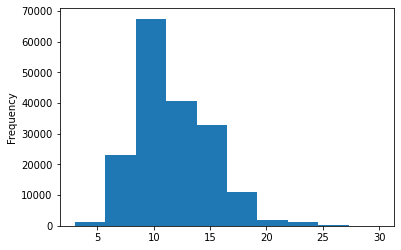

In [ ]:
train_df.total_lines.plot.hist();

## Labels into numbers

In [ ]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Extract labels (target columns) and encode them into integers.
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels Look like
train_labels_encoded[:20]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4])

In the Labelencoder() instance, we can get the class names and number of classes using the `classes_` attribute.

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Preparing our data for deep sequence models
Let's set up a vectorization layer and embedding layer to convert our data into numbers and figure out the relationships between those numbers.

In our firts Vectorization layer we'll vectorize sentence by sentence, and it works best when they're all the same length, because that way we create batches of the same size.

In [ ]:
# let's figure out how long is each sentences on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338435903132638

(0.0, 150.0)

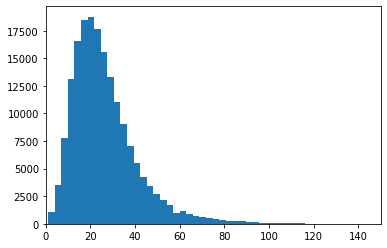

In [ ]:
# And their distibution?
plt.hist(sent_lens, bins=100);
len(sent_lens)
plt.xlim(0,150)

In [ ]:
# How long convers the 97% of the sentence lengths?
output_seq_len = int(np.percentile(sent_lens, 97)) # compute the q-th percentile of the data along the specified axis
output_seq_len

62

This is useful because when we turn all of the sentences into numbers, they have to be at the same length, and using a maximun length of 62 seems quite inclusive. 😀

This means that sentences below 62 get padded with zeros, and sentences with a length above 62 get cut off.

## Create Text vectorizer



### Maching a Worlds tokenizer

In [ ]:
# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=68000, # Consulting the paper we can find out that this is the maximum # of words
                                    output_sequence_length=62)

In [ ]:
# Adapt the text vectorizer layer.
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out our text vectorizer
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\n Vectorized text:\n{text_vectorizer([target_sentence])}")

Text:
muf was performed for a mean time of 12 minutes in both groups .

Length of text: 14

 Vectorized text:
[[29144    10   165    11     8    58    64     4    76   377     5    55
     24     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


Now using the `get_vocabulary()` method of our `text_vectorizer` we can find out some tidbits about our text.

In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary:{rct_20k_text_vocab[:10]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-15:-5]}")

Number of words in vocabulary: 68000
Most common words in the vocabulary:['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in the vocabulary: ['httpwwwanzctrorgaudefaultaspx', 'httpwwwanzctrorgauactrn12609000321246aspx', 'httpwebcitationorg6luqvn12m', 'httpswwwuclacukpriment', 'httpswwwclinicaltrialsregistereuctrsearchtrial200700484060gb', 'httpswwwanzctrorgautrialregistrationtrialreviewaspxid362489', 'httpswwwanzctrorgautrialregistrationtrialreviewaspxid347505', 'httpswwwanzctrorgautrialregistrationtrialreviewaspxid343307', 'httpswwwanzctrorgautrialregistrationtrialreviewaspxactrn12611000081910', 'httpswwwanzctrorgau']


Also if we want to consult the configuration of this `text_vectorizer` we can use his `get_config()` method.

In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 62,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Creating a custom embedding layer.

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
print(f"Embedded Sentence shape: \n {vectorized_sentence.shape}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded Sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
muf was performed for a mean time of 12 minutes in both groups .

Sentence after vectorization (before embedding):
[[29144    10   165    11     8    58    64     4    76   377     5    55
     24     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]

Embedded Sentence shape: 
 (1, 62)
Sentence after embedding: 
 [[[-0.00579542 -0.02501218  0.02292557 ...  0.03597454 -0.0010826
    0.00855962]
  [-0.03760873 -0.01518809 -0.04204919 ...  0.01474095 -0.03893887
    0.01736725]
  [-0.04755064  0.03925766 -0.0158154  ...  0.0202341   0.0234842
    0.03068148]
  ...
  [-0.01043686 -0.00815102 -0.02880217 ... -0.04861974  0.03169632
   -0.02446151]
  [-0.01043686 -0.00815102 -0.02880217 ... -0.04861974  0.03169632
 

## Create datasets

We'll use the DATA Api to create a batched `PrefetchDataset` that runs faster as possible in our GPU, for reach that we can use the methods  [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and  [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) and the parameter tf.data.Autotune, that will allow Tensorflow to determine the optimal amount of compute to use prepare datasets.

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the tensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Building the models

Now that the our data is ready, it's time to setup a series of moedelling experiments.

We'll start by creating a simple baseline model to obtain a score that we'll try to beat by building more and more complex models.

### Model 0: The Baseline

Using the [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we find that the recomed model for this problem is the TF-IDF Multinomial Naive Bayes.

In [ ]:
# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])


# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X= val_sentences,
              y= val_labels_encoded)

0.7317291142592347

Looks like 73.17% accuracy will be the number to beat with our depeper models. 


In [ ]:
# Make predictions with the base_model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 1, 3, ..., 4, 4, 1])

In [ ]:
# Calculate the base line results
baseline_results = calculate_results(y_true= val_labels_encoded,
                                     y_pred= baseline_preds)
baseline_results

{'accuracy': 73.17291142592347,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347,
 'f1': 0.7058060715307974}

Alright, we've mow got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure

    Input (text) -> Tokenize -> Embedding -> Layers -> Output

## Model 1 : Conv1D with token embeddings


In [ ]:
# Create 1D convolutional model to process sequences 
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs.
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 62)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 62, 128)          8704000   
                                                                 
 conv1d (Conv1D)             (None, 62, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model with 10% of our dataset
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps= int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 53ms/step - loss: 0.9120 - accuracy: 0.6391 - val_loss: 0.6757 - val_accuracy: 0.7434
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6439 - accuracy: 0.7604 - val_loss: 0.6111 - val_accuracy: 0.7739
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6053 - accuracy: 0.7775 - val_loss: 0.5884 - val_accuracy: 0.7839


In [ ]:
# Evaluate on 100% of the validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5849 - accuracy: 0.7895


[0.5849097371101379, 0.7894545197486877]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:3]

945/945 [==============================] - 3s 3ms/step


array([[4.4423717e-01, 1.3229983e-01, 6.1544169e-02, 3.3903667e-01,
        2.2882039e-02],
       [4.7728145e-01, 2.4314718e-01, 1.3832712e-02, 2.5626472e-01,
        9.4740307e-03],
       [1.9012998e-01, 4.7506155e-03, 1.4203333e-03, 8.0366480e-01,
        3.4300028e-05]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds= tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.94545213822323,
 'precision': 0.783364964862195,
 'recall': 0.7894545213822323,
 'f1': 0.785495873250877}

## Model_2 : Feature Extraction with pretrained token embeddings

In the paper, they mention that they are using are using a [pretrained GloVe embedding](https://keras.io/examples/nlp/pretrained_word_embeddings/) in their architecture. We can do the same and use that embedding, but i want to try something different so i'll use the [TensorFlow Hub Bert PubMed Expert](https://tfhub.dev/google/experts/bert/pubmed/2). (Bidirectional Encoder Representations from Transformers)

This Saved model is associate with a [preprocessing model](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3) that transforms plain text inputs into the format the can be fed into Bert encoder and it'll give a dictionary with 2 outputs as keys:

  * **Pouled_output:** Undimencional output that capture information of the plane text
  * **Sequence_output:** 3D output wich contains the secuntial and contextual information for each token in the text. 

In [ ]:
!pip3 install --quiet tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 59.1 MB/s eta 0:00:00


In [ ]:
import tensorflow_text as tf_text
# Load the Bert encoder 
preprocessor_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
                                    input_shape=[],
                                    dtype=tf.string,
                                    trainable=False,
                                    name= 'Bert_preprocessor')
bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2',
                      trainable=False)

Beutiful, let's test the pretrained_model on a random sentence.

In [ ]:
# Test out the bert_embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
bert_inputs = preprocessor_layer([random_training_sentence]) 

# Feed the inputs to the model to get the pooled
bert_outputs = bert_layer(bert_inputs, training= False)
pooled_output = bert_outputs['pooled_output']
sequence_output = bert_outputs["sequence_output"]

print(f"Random training sentence before embedding:\n {random_training_sentence}\n")
print(f"Random training sentence after the embedding \n {sequence_output}\n")
print(f"Shape of sentence embedding:\n {sequence_output.shape}")

Random training sentence before embedding:
 the number of applications of misoprostol ( two versus three , p < 0.001 ) and the dose of misoprostol used was lower in the study group ( 100 versus 200 g , p < 0.001 ) .

Random training sentence after the embedding 
 [[[-0.05767794  0.41497445 -0.6197192  ... -0.5904498  -0.8907485
   -1.2337365 ]
  [ 0.38650608 -0.3732014   1.1731983  ... -0.3612631  -1.2036817
    1.3543106 ]
  [ 0.548884   -0.6910326   0.34246916 ... -1.193178   -0.92734283
    1.4440308 ]
  ...
  [ 1.0674872  -0.40634784 -0.1972462  ... -0.39840418  0.9821726
   -2.8084395 ]
  [ 2.0792181   0.23951478 -0.53456527 ... -0.15807435  0.3911799
    0.6663241 ]
  [ 1.2349474  -0.6048124   0.24192658 ... -0.35363293 -0.02236548
    2.053284  ]]]

Shape of sentence embedding:
 (1, 128, 768)


Since our project problem is about a sentence classification task we going to use the `sequence_ouput` in our model.

In [ ]:
from keras.layers.serialization import activation
# Tokenize batches & Build the model
bert_inputs = layers.Input(shape=(), dtype=tf.string)
preprocessed_text = preprocessor_layer(bert_inputs)
bert_outputs= bert_layer(preprocessed_text)
sequence_output = bert_outputs["sequence_output"]
x = layers.Dense(128, activation="relu")(sequence_output)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs=bert_inputs,
                         outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 Bert_preprocessor (KerasLayer)  {'input_type_ids':   0          ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 257s 426ms/step - loss: 0.4909 - accuracy: 0.8275 - val_loss: 0.3918 - val_accuracy: 0.8640
Epoch 2/3
562/562 [==============================] - 228s 405ms/step - loss: 0.4084 - accuracy: 0.8546 - val_loss: 0.3883 - val_accuracy: 0.8637
Epoch 3/3
562/562 [==============================] - 237s 421ms/step - loss: 0.3949 - accuracy: 0.8590 - val_loss: 0.3925 - val_accuracy: 0.8567


In [ ]:
# Evaluate the model_2 
model_2.evaluate(valid_dataset)

945/945 [==============================] - 328s 347ms/step - loss: 0.3869 - accuracy: 0.8585


[0.3868773579597473, 0.8584999442100525]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 328s 346ms/step


array([[5.0409454e-01, 2.7546415e-01, 7.7238297e-03, 1.7783031e-01,
        3.4887183e-02],
       [5.9567827e-01, 7.0569634e-02, 5.1924428e-03, 3.2051036e-01,
        8.0492832e-03],
       [3.7416431e-01, 1.9420242e-03, 7.4253173e-04, 6.2286085e-01,
        2.9033070e-04],
       ...,
       [2.1351606e-04, 2.4195325e-03, 1.3041990e-02, 2.2477476e-04,
        9.8410022e-01],
       [3.4905571e-02, 7.8339076e-01, 1.9956185e-03, 2.6419394e-02,
        1.5328857e-01],
       [4.5375511e-02, 9.3442583e-01, 1.4462149e-02, 2.9259373e-03,
        2.8105075e-03]], dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                  y_pred= model_2_preds)
model_2_results

{'accuracy': 85.84999338011386,
 'precision': 0.8604673768169611,
 'recall': 0.8584999338011386,
 'f1': 0.8584397446985519}

## Model_3: Conv 1D with character embeddings.


### Making a character tokenizer

In [ ]:
# Spliting sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test the splitting into characters
split_chars(random_training_sentence)

't h e   n u m b e r   o f   a p p l i c a t i o n s   o f   m i s o p r o s t o l   (   t w o   v e r s u s   t h r e e   ,   p   <   0 . 0 0 1   )   a n d   t h e   d o s e   o f   m i s o p r o s t o l   u s e d   w a s   l o w e r   i n   t h e   s t u d y   g r o u p   (   1 0 0   v e r s u s   2 0 0   g   ,   p   <   0 . 0 0 1   )   .'

Ok, now let's create character-level datasets by splitting our sequence datasets into characters.

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars= [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


train_chars[7]


't h e   m e a n   d i f f e r e n c e   b e t w e e n   t r e a t m e n t   a r m s   (   9 5   %   c i   )   w a s   1 0 . 9   (   4 . 8 - 1 8   . 0   )   ,   p   <   0 . 0 0 1   ;   9 . 5   (   3 . 7 - 1 5   . 4   )   ,   p   <   0 . 0 5   ;   1 5 . 7   (   5 . 3 - 2 6   . 1   )   ,   p   <   0 . 0 0 1   ;   a n d   8 6 . 9   (   2 9 . 8 - 1 4 4   . 1   )   ,   p   <   0 . 0 5   ,   r e s p e c t i v e l y   .'

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

152.006276383026

(array([1.29344e+05, 4.75570e+04, 2.84500e+03, 2.37000e+02, 4.10000e+01,
        1.30000e+01, 1.00000e+00, 2.00000e+00]),
 array([   2. ,  183.5,  365. ,  546.5,  728. ,  909.5, 1091. , 1272.5,
        1454. ]),
 <BarContainer object of 8 artists>)

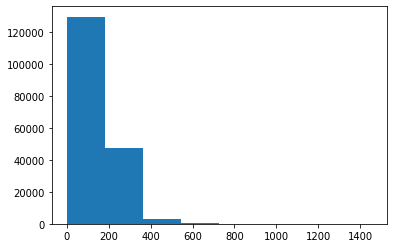

In [ ]:
# Check the distribution of our sequences at character-level
plt.hist(char_lens, bins=8)

In [ ]:
# Find what character length covers 96% of sequences
output_seq_char_len = int(np.percentile(char_lens,96))
output_seq_char_len

310

This will be the `output_sequence_length` in our TextVectorization layer.

In [ ]:
# Token vectorizer instance
import string
NUM_CHAR_TOKENS = len(string.ascii_lowercase+ string.digits+string.punctuation) + 2 #Keyboard character for the chAr-level embedding
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS, #70
                                    standardize= "lower_and_strip_punctuation",
                                    output_sequence_length=output_seq_char_len, #310
                                    name="char_vectorizer")

# Adact character vectrizer to training characters
char_vectorizer.adapt(train_chars)

Let's checkout some characteristics about the vectorizer instance using `get_vocabulary()` method.

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Different characters:\n {len(char_vocab)}")
print(f"Most common ones:\n{char_vocab[:5]}")
print(f"Lest comoon ones:\n {char_vocab[-5:]}")


Different characters:
 38
Most common ones:
['', '[UNK]', 'e', 't', 'i']
Lest comoon ones:
 ['8', '7', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars.shape}")
print(f"\nLength of vectorized chars: {vectorized_chars.shape}")

Charified text:
t h e   p u r p o s e   o f   o u r   s t u d y   w a s   t w o - f o l d   :   1   )   a d a p t   a n d   t e s t   a   s o c i a l   s u p p o r t   m e a s u r e   s p e c i f i c   t o   t h e   e x p e r i e n c e s   o f   a f r i c a n   a m e r i c a n   w o m e n   w i t h   t y p e   2   d i a b e t e s   m e l l i t u s   (   t 2 d m   )   ;   2   )   e x a m i n e   i t s   r e l a t i o n s h i p   t o   p s y c h o s o c i a l   m e a s u r e s   .

Length of chars: 192

Vectorized chars:
(1, 310)

Length of vectorized chars: (1, 310)


### Creating a character-level embedding

In [ ]:
# Create token embedding layer
character_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                               output_dim=25, # as the paper architecture
                               mask_zero=False,
                               name="character_embed")
# Show example embedding
print(f"Sentence before vectorization:\n{random_train_chars}\n")
vectorized_sentence_by_chars = char_vectorizer([random_train_chars])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence_by_chars}\n")
print(f"Vectorizer Sentence shape: \n {vectorized_sentence_by_chars.shape}")
char_embedding_sample = character_embed(vectorized_sentence_by_chars)
print(f"Sentence after embedding: \n {char_embedding_sample}\n")
print(f"Embedded Sentence shape: {char_embedding_sample.shape}")

Sentence before vectorization:
t h e   p u r p o s e   o f   o u r   s t u d y   w a s   t w o - f o l d   :   1   )   a d a p t   a n d   t e s t   a   s o c i a l   s u p p o r t   m e a s u r e   s p e c i f i c   t o   t h e   e x p e r i e n c e s   o f   a f r i c a n   a m e r i c a n   w o m e n   w i t h   t y p e   2   d i a b e t e s   m e l l i t u s   (   t 2 d m   )   ;   2   )   e x a m i n e   i t s   r e l a t i o n s h i p   t o   p s y c h o s o c i a l   m e a s u r e s   .

Sentence after vectorization (before embedding):
[[ 3 13  2 14 16  8 14  7  9  2  7 17  7 16  8  9  3 16 10 19 20  5  9  3
  20  7 17  7 12 10 24  5 10  5 14  3  5  6 10  3  2  9  3  5  9  7 11  4
   5 12  9 16 14 14  7  8  3 15  2  5  9 16  8  2  9 14  2 11  4 17  4 11
   3  7  3 13  2  2 30 14  2  8  4  2  6 11  2  9  7 17  5 17  8  4 11  5
   6  5 15  2  8  4 11  5  6 20  7 15  2  6 20  4  3 13  3 19 14  2 25 10
   4  5 22  2  3  2  9 15  2 12 12  4  3 16  9  3 25 10 15 25  2 30  5 15
   4  6

### Building a Conv1D model.

In [ ]:
## Make Conv1D on chars only
inputs = layers.Input(shape=(1,),dtype="string") # 1 sequence at the time
char_vectors = char_vectorizer(inputs)
char_embed = character_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embed)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embedding")
# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 310)              0         
 ization)                                                        
                                                                 
 character_embed (Embedding)  (None, 310, 25)          1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 310, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# create char dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch= int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data = val_char_dataset,
                              validation_steps=int(0.1* len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2175 - accuracy: 0.5040 - val_loss: 0.9932 - val_accuracy: 0.6054
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9423 - accuracy: 0.6189 - val_loss: 0.8892 - val_accuracy: 0.6586
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.8715 - accuracy: 0.6588 - val_loss: 0.8269 - val_accuracy: 0.6815


In [ ]:
# Evalute it
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8315 - accuracy: 0.6752


[0.8315187096595764, 0.6752283573150635]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.2810364 , 0.40283388, 0.04941481, 0.2463217 , 0.02039325],
       [0.1990319 , 0.4561872 , 0.07822333, 0.21766078, 0.04889683],
       [0.186865  , 0.23244698, 0.2303179 , 0.30813098, 0.04223919],
       ...,
       [0.00456183, 0.00591578, 0.05227545, 0.00404824, 0.9331987 ],
       [0.04230701, 0.0912904 , 0.34601885, 0.0315618 , 0.488822  ],
       [0.35913673, 0.49471942, 0.04140818, 0.08535918, 0.01937649]],
      dtype=float32)

In [ ]:
# Convert prediction to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred= model_3_preds)
model_3_results

{'accuracy': 67.52283860717596,
 'precision': 0.6689493712403213,
 'recall': 0.6752283860717596,
 'f1': 0.6658724589696622}

## Model_4: token embeddings + Char embeddings
[The paper ](https://arxiv.org/pdf/1612.05251.pdf) that we are trying to replicate are using a particular way of embedding his data,  they are using a model that recibe two inputs at the time a token embedding and a character embedding , soo for for tackle this, let's make that make the same...

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=(), dtype= tf.string, name="token_input")
preprocessed_text = preprocessor_layer(token_inputs)
bert_outputs= bert_layer(preprocessed_text)
sequence_output = bert_outputs["sequence_output"]
x = layers.Dense(128, activation="relu")(sequence_output)
token_output = layers.GlobalMaxPool1D()(x)

token_model = tf.keras.Model(inputs=token_inputs,
                        outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype="string") # 1 sequence at the time
char_vectors = char_vectorizer(char_inputs)
char_embed = character_embed(char_vectors)
char_bi_lstm= layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs= char_bi_lstm)

# 3. Concatenate token and char inputs (create hydrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hydrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers
combine_dropout= layers.Dropout(0.5)(token_char_concat)
combine_dense = layers.Dense(200, activation="relu")(combine_dropout)
final_dropout = layers.Dropout(0.5)(combine_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs.
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 Bert_preprocessor (KerasLayer)  {'input_type_ids':   0          ['token_input[0][0]']            
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                      

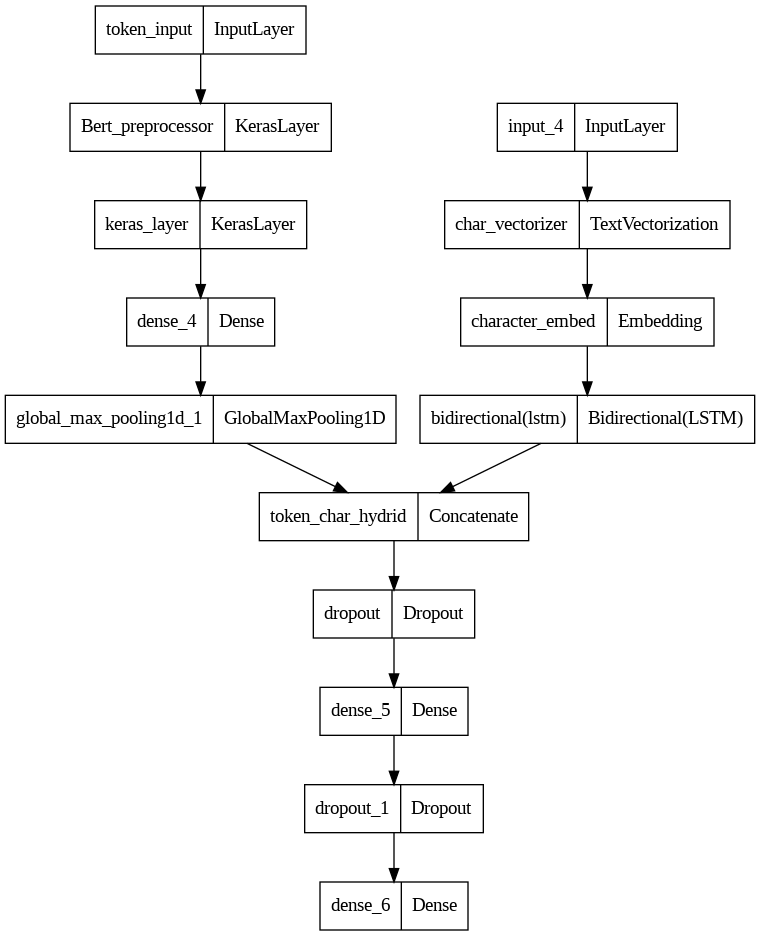

In [ ]:
# Plot hybrid token and character model
plot_model(model_4)

In [ ]:
# Compile model_4
model_4.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

### Token and character data into a tf dataset

In [ ]:
# Combine chars and tokens into a Training dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Mkae labels
train_char_token_dataset =tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 

# Prefetch and batch train data.
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Combine chars and tokens datasets into a validation dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # Make label
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch valid_data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset,val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch= int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 248s 428ms/step - loss: 1.1981 - accuracy: 0.5569 - val_loss: 0.5562 - val_accuracy: 0.8178
Epoch 2/3
562/562 [==============================] - 239s 425ms/step - loss: 0.6734 - accuracy: 0.7573 - val_loss: 0.4680 - val_accuracy: 0.8461
Epoch 3/3
562/562 [==============================] - 239s 425ms/step - loss: 0.5783 - accuracy: 0.7960 - val_loss: 0.4247 - val_accuracy: 0.8541


85.37 con average max pool, insteed of maxpoollayer

In [ ]:
# Evaluate on the validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 334s 353ms/step - loss: 0.4241 - accuracy: 0.8525


[0.42408135533332825, 0.8525420427322388]

In [ ]:
# make predictions using the token-character model hydrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 336s 353ms/step


In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Get results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 85.2542036276976,
 'precision': 0.8510782654585611,
 'recall': 0.852542036276976,
 'f1': 0.8515089250707927}

## Model_5: Add possional embeddings

Our final move is to use our knowledge about the problem. When we read the abstracts, we expect their sections to appear in order. Therefore, it may be a good idea to inform our model of this, and to do that, we'll establish a `line embedding layer.`

To do this, we need to take some considerations into account. We already have the number of lines and the total lines in our dictionary. However, to prevent our model from making extra considerations, we'll use a one-hot encoder format to pass this information to it.

<AxesSubplot:ylabel='Frequency'>

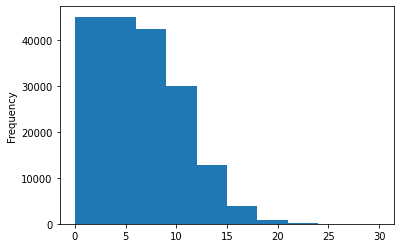

In [ ]:
# Check the distribution of "line number"
train_df.line_number.plot.hist()

Seems like 15 is a aproppiate number for the # of sentences

In [ ]:
# Use tensorFlow to create one-hot-encoded tensors
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
# Check one-hot encoded "line_number"
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:5]

(TensorShape([180040, 15]), <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

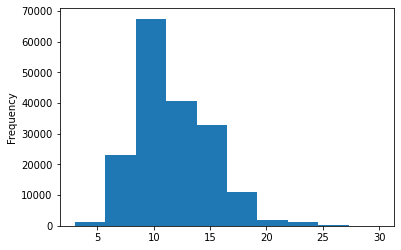

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Total line one-hot
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:5]

(TensorShape([180040, 20]), <tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>)

### Building the model

In [ ]:
train_line_numbers_one_hot[0]

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype= tf.string, name="token_input")
preprocessed_text = preprocessor_layer(token_inputs)
bert_outputs= bert_layer(preprocessed_text)
sequence_output = bert_outputs["sequence_output"]
x = layers.Dense(128, activation="relu")(sequence_output)
token_output = layers.GlobalMaxPool1D()(x)

token_model = tf.keras.Model(inputs=token_inputs,
                        outputs=token_output)

# 2. Char inputs
token_inputs = layers.Input(shape=(), dtype="string", name ="Char_Inputs")
char_vectors = char_vectorizer(char_inputs)
char_embed = character_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embed)
char_model = tf.keras.Model(inputs= char_inputs,
                            outputs= char_bi_lstm)

# 3. Line numbers inputs.
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32,activation ="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype= tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Concanate the 3 models
## 5.1 Char and Tokens embeddings
combined_embeddings = layers.Concatenate(name="token_char_hydrid_embedding")([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

## 5.2 Adding positionam embeddings
z = layers.Concatenate(name="Token_positional_char_embedding")([line_number_model.output,
                                                              total_line_model.output,
                                                              z])

# 6. create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 7. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input], 
                         outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 Bert_preprocessor (KerasLayer)  {'input_type_ids':   0          ['token_input[0][0]']            
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

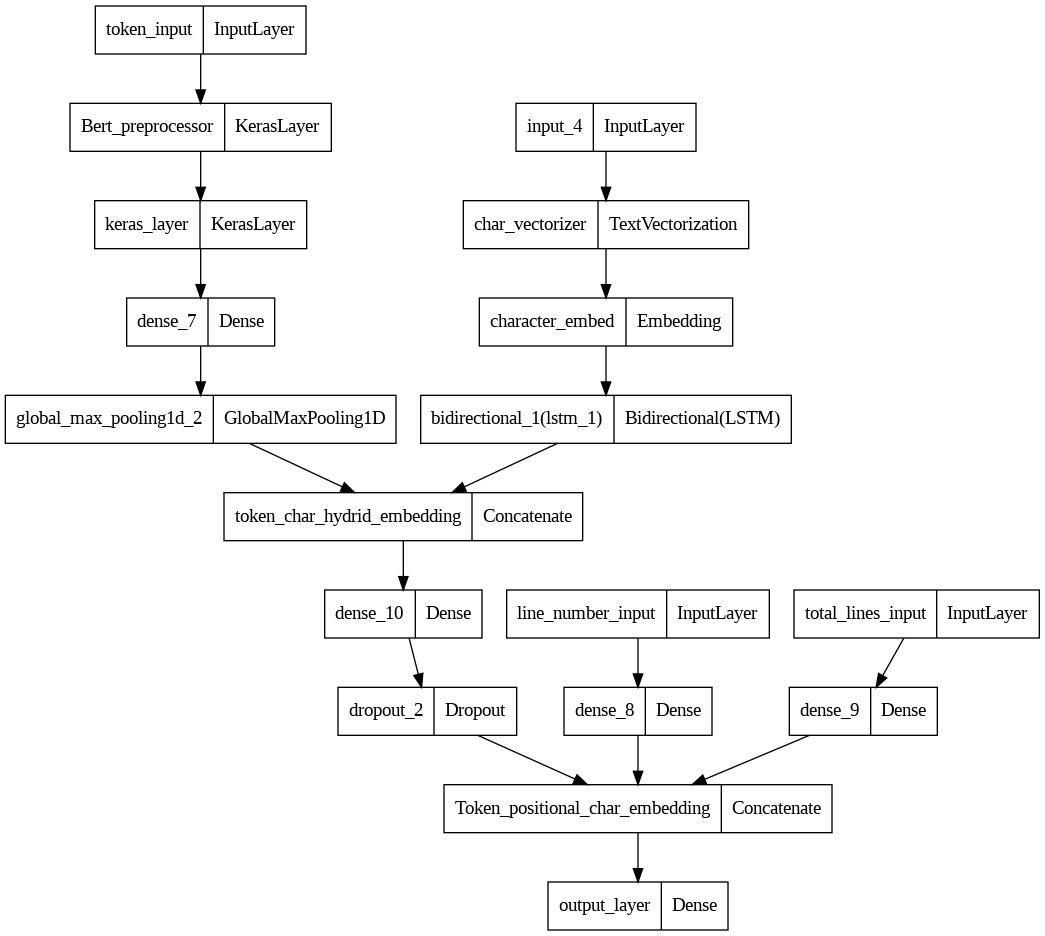

In [ ]:
plot_model(model_5)

In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa5cd466460> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fa530885640> False
<keras.engine.input_layer.InputLayer object at 0x7fa4c96651f0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fa676f80d30> False
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fa520946190> True
<keras.layers.core.dense.Dense object at 0x7fa527eb9cd0> True
<keras.layers.core.embedding.Embedding object at 0x7fa479dc1430> True
<keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x7fa5cd466610> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7fa4c956dc70> True
<keras.layers.merging.concatenate.Concatenate object at 0x7fa527e43e20> True
<keras.engine.input_layer.InputLayer object at 0x7fa4c949b610> True
<keras.engine.input_layer.InputLayer object at 0x7fa527e1d760> True
<keras.layers.core.dense.Dense object at 0x7fa4c953ec40> True
<keras.layers.core.dense.Dense object at 0x7fa4c9

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Making the batches

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars))
                                                                # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              epochs=100,
                              validation_data=val_pos_char_token_dataset,
                              callbacks=([checkpoint_callback,earlystopping_callback]))     

### Fitting the model

In [ ]:
# Make predictions
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

In [ ]:
# Calculate results
model_5_results = calculate_results(y_true= val_labels_encoded,
                                    y_pred= model_5_preds)
model_5_results

# Evaluting the models

## Compare model results

In [ ]:
# Combine model results into a DataFame
all_models_results = pd.DataFrame({"baseline": baseline_results,
                                   "custom_token_embed_conv1d": model_1_results,
                                   "pretrained_token_embed": model_2_results,
                                   "custom_char_embed_conv1d": model_3_results,
                                   "hybrid_char_token_embed": model_4_results,
                                   "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_models_results.transpose()
all_model_results

In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
all_model_results = all_model_results.sort_values(by="accuracy", ascending=False)

In [ ]:
all_model_results

In [ ]:
# Plot and compate all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

# Training the best model.

In [ ]:
# let's set up a couple of callbacks
save_dir = 'best_model'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_dir, monito='val_accuracy', save_best_only=True)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=2)

In [ ]:
# Fit the token, char and positional embedding model
history_best_model = best_model.fit(train_pos_char_token_dataset,
                              epochs=100,
                              validation_data=val_pos_char_token_dataset,
                              callbacks=([checkpoint_callback,earlystopping_callback]))                

Epoch 1/100
5627/5627 [==============================] - ETA: 0s - loss: 0.8812 - accuracy: 0.8798

5627/5627 [==============================] - 2440s 432ms/step - loss: 0.8812 - accuracy: 0.8798 - val_loss: 0.8395 - val_accuracy: 0.8915
Epoch 2/100
5627/5627 [==============================] - ETA: 0s - loss: 0.8449 - accuracy: 0.8965

5627/5627 [==============================] - 2438s 433ms/step - loss: 0.8449 - accuracy: 0.8965 - val_loss: 0.8291 - val_accuracy: 0.8975
Epoch 3/100
5627/5627 [==============================] - 2458s 437ms/step - loss: 0.8378 - accuracy: 0.9002 - val_loss: 0.8315 - val_accuracy: 0.8970
Epoch 4/100
 218/5627 [>.............................] - ETA: 33:28 - loss: 0.8434 - accuracy: 0.9001